In [58]:
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/First_Multiclass_Model'
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = ["DRll01","HT_jets","sumPsbtag","met_met","Mll01","DEtall_SS","jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [26]:
#samples, feature_names, class_names, class_no = load_input_file('data/sstt_multiclass_background_V03.h5', features_to_ignore)
samples, feature_names, class_names, class_no = load_input_file('data/sstt_V04.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 20 features on the dataset 11 features were loaded: 

DPhill_SS
HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
DeltaR_max_lep_bjet77
DeltaR_min_lep_bjet77
DRjj_lead
jet_pt0_nofwd
nJets_OR
randomRunNumber
 
Dataset contains extra labels for different backgrounds!
Class 0  :  679239
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Dataset contains 679239 Signal events and 1425994 Background events.


In [27]:
Number = np.squeeze((input_features[:,-1]).astype(int))
Phi = input_features[:,0]
#Number = np.arange(0,1679947)
feature_names = feature_names[1:-1]
input_features = input_features[:,1:-1]

In [28]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)
print(class_names)
print(class_no)
No_Classes = class_no.max()+1

['signal' 'ttZ' 'tty' 'ttW' 'tttt' 'ttH' 'Other' 'Diboson' 'Fakes']
[0 1 2 3 4 5 6 7 8]


In [29]:
ScaleWeights(targets,weights)
#scale the input between 0-1
scaler = StandardScaler().fit(input_features)
input_scaled = scaler.transform(input_features)


======Weight Statistic========================================
Weights::        W(1)=1200.48, W(0)=2983.69
Scaled weights:: W(1)=1.05262e+06, W(0)=1.05262e+06


In [30]:
odd, even = Fold_Odd_Even(input_scaled, targets, weights, class_labels, Number)

In [31]:
#train, val, test = Train_Val_Test_Split(input_scaled, targets, weights, class_labels)
input_shape = odd[0].shape[1]
n_epochs = 50
batch_size = 20000

In [32]:
def Create_Model_basic(input_shape):
    layer_opts = dict( activation = 'sigmoid', kernel_initializer = initializers.glorot_normal(seed=seed))
    input_layer = Kl.Input(shape = input_shape )
    x = Kl.Dense( 36, **layer_opts) (input_layer)
    x = Kl.Dense( 48, **layer_opts) (x)
    y_pred = Kl.Dense( 9., activation = 'softmax', name = "OutputLayer" )(x)
    model = Km.Model(inputs= input_layer, outputs=y_pred )
    model_optimizer = Adam(lr=0.0001)
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [36]:
def Train_Odd_Even(odd, even, n_epochs = 400, batch_size = 2000):
    fit_history_list = []
    model_list = []
    input_shape = odd[0].shape[1]

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

    X_odd, X_val_odd, weights_odd, weights_val_odd, y_odd, y_val_odd, = train_test_split(odd[0], odd[2], odd[3], test_size=0.2)
    X_even, X_val_even, weights_even, weights_val_even, y_even, y_val_even, = train_test_split(even[0], even[2], even[3], test_size=0.2)
    
    y_odd = np.eye(No_Classes)[y_odd]
    y_val_odd = np.eye(No_Classes)[y_val_odd]
    y_even = np.eye(No_Classes)[y_even]
    y_val_even =np.eye(No_Classes)[y_val_even]
    
    model_odd = Create_Model_basic(input_shape)
    model_even = Create_Model_basic(input_shape)
    fit_history_odd = model_odd.fit(X_odd, y_odd, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_odd, y_val_odd, weights_val_odd), sample_weight=weights_odd, verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #
    fit_history_even = model_even.fit(X_even, y_even, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_even, y_val_even, weights_val_even), sample_weight=weights_even, verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #

    return fit_history_odd, model_odd, fit_history_even, model_even

In [37]:
hist_odd, model_odd, hist_even, model_even = Train_Odd_Even(odd, even, n_epochs = n_epochs, batch_size = batch_size)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 36)                360       
_________________________________________________________________
dense_9 (Dense)              (None, 48)                1776      
_________________________________________________________________
OutputLayer (Dense)          (None, 9)                 441       
Total params: 2,577
Trainable params: 2,577
Non-trainable params: 0
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 9)]               0         
________________________________________

857245/857245 [==============================] - 0s 1us/sample - loss: 1.0016 - accuracy: 0.4598 - val_loss: 1.0235 - val_accuracy: 0.4393
Epoch 44/50
857245/857245 [==============================] - 0s 1us/sample - loss: 1.0023 - accuracy: 0.4582 - val_loss: 1.0208 - val_accuracy: 0.4478
Epoch 45/50
857245/857245 [==============================] - 0s 1us/sample - loss: 1.0033 - accuracy: 0.4583 - val_loss: 1.0204 - val_accuracy: 0.4681
Epoch 46/50
857245/857245 [==============================] - 0s 1us/sample - loss: 1.0009 - accuracy: 0.4598 - val_loss: 1.0180 - val_accuracy: 0.4689
Epoch 47/50
857245/857245 [==============================] - 0s 1us/sample - loss: 1.0007 - accuracy: 0.4598 - val_loss: 1.0204 - val_accuracy: 0.4455
Epoch 48/50
857245/857245 [==============================] - 0s 1us/sample - loss: 1.0013 - accuracy: 0.4586 - val_loss: 1.0189 - val_accuracy: 0.4630
Epoch 49/50
857245/857245 [==============================] - 1s 1us/sample - loss: 0.9999 - accuracy: 0.45

826940/826940 [==============================] - 0s 1us/sample - loss: 1.0228 - accuracy: 0.4575 - val_loss: 1.0521 - val_accuracy: 0.4715
Epoch 48/50
826940/826940 [==============================] - 0s 1us/sample - loss: 1.0248 - accuracy: 0.4581 - val_loss: 1.0485 - val_accuracy: 0.4557
Epoch 49/50
826940/826940 [==============================] - 0s 1us/sample - loss: 1.0228 - accuracy: 0.4584 - val_loss: 1.0470 - val_accuracy: 0.4509
Epoch 50/50
826940/826940 [==============================] - 0s 1us/sample - loss: 1.0223 - accuracy: 0.4569 - val_loss: 1.0465 - val_accuracy: 0.4623


In [38]:
P = model_odd.predict(even[0])

In [51]:
Binary = P[:,0:2].sum(axis=1)

In [55]:
signal_prediction = Binary[even[1] == 1]
background_prediction = Binary[even[1] != 1]

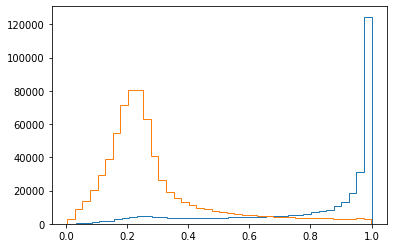

<Figure size 432x288 with 0 Axes>

In [56]:
plt.hist(signal_prediction, bins=40, histtype='step')
plt.hist(background_prediction, bins=40, histtype='step')
plt.show()
plt.clf()

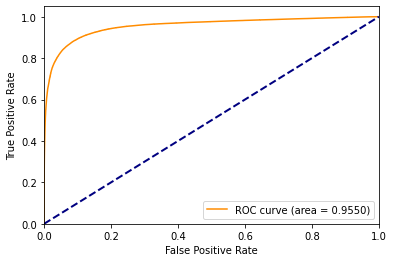

In [57]:
pred = Binary
truth = even[1]
fpr, tpr, thr = roc_curve(truth, pred, sample_weight=even[2])
roc_auc = auc(fpr, tpr)

fig = plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

In [80]:
def Multiclass_NNoutput_Plots(model, data):
    Prediction = model.predict(data[0])
    Truth = np.eye(No_Classes)[data[3]]
    histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
    for i in range(No_Classes):
        Prediction[:,i] = Prediction[:,i] / np.max(Prediction[:,i])
        for j in range(No_Classes):
            plt.hist(Prediction[:,i][Truth[:,j] == 1], label=class_names[j], **histargs)
        plt.legend()
        plt.xlabel("NN output for "+ class_names[i], horizontalalignment='right', x=1)
        plt.xlim([0,1])
        plt.ylabel("Density")
        plt.show()
        plt.clf()

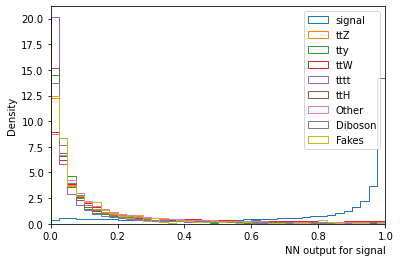

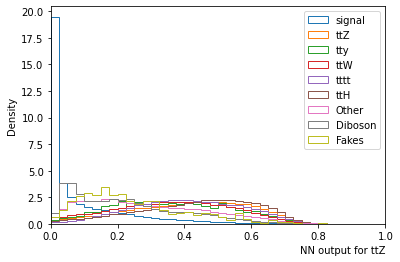

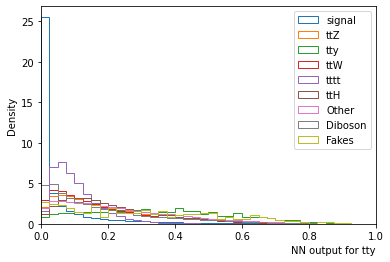

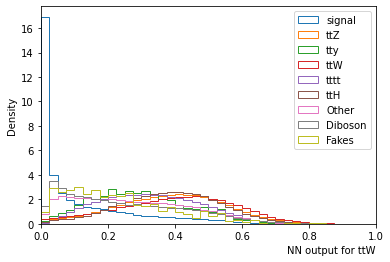

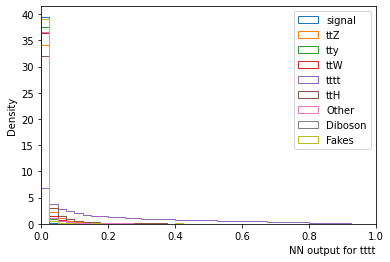

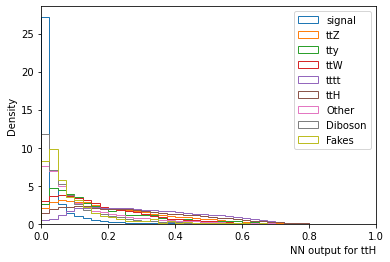

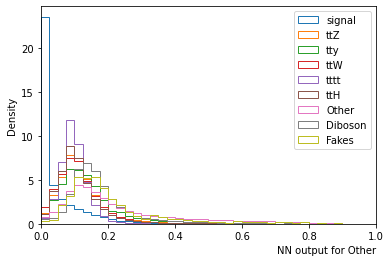

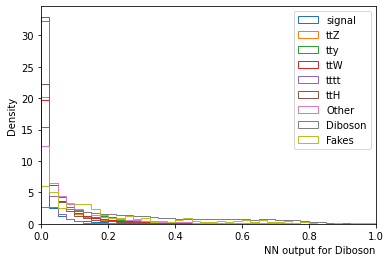

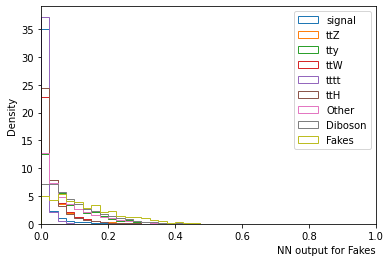

<Figure size 432x288 with 0 Axes>

In [81]:
Multiclass_NNoutput_Plots(model_odd, even)

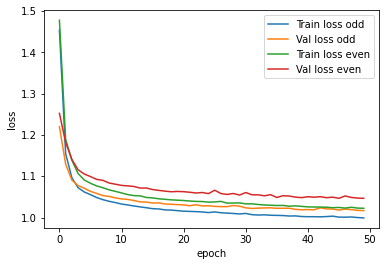

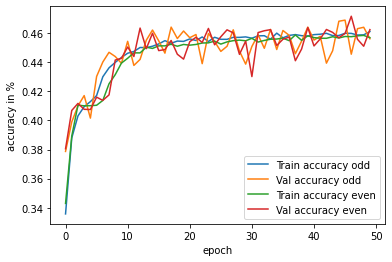

In [42]:
history_list = [hist_odd, hist_even]
Plot_Metrics_KFold(history_list, path_tosave)

In [10]:
Save_Model(model_odd, path_tosave, "_odd")
Save_Model(model_even, path_tosave, "_even")

pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))

Saving architecture to: /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/V04_new_features/architecture_odd.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/V04_new_features/weights_odd.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/V04_new_features/architecture_even.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/V04_new_features/weights_even.h5


# Evaluation

In [8]:
model_odd = Load_Model(path_tosave, name="_odd")
model_even = Load_Model(path_tosave, name="_even")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/24_05_2022/architecture_odd.json, /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/24_05_2022/weights_odd.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/24_05_2022/architecture_even.json, /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/24_05_2022/weights_even.h5)


/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


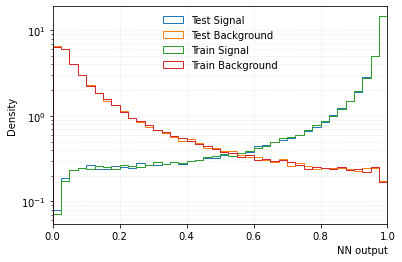

In [9]:
Plot_NN_Output(model_odd, odd, even, path_tosave, True)

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


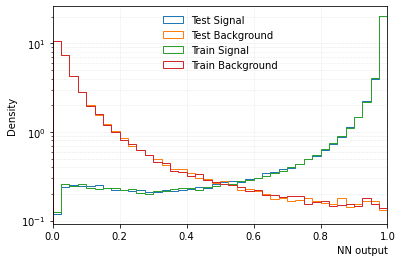

In [10]:
Plot_NN_Output(model_even, even, odd, path_tosave, True, False)

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


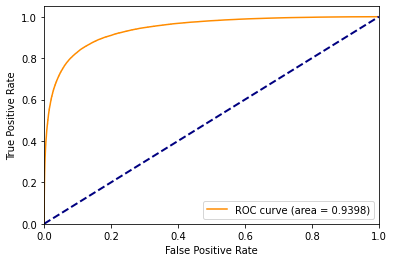

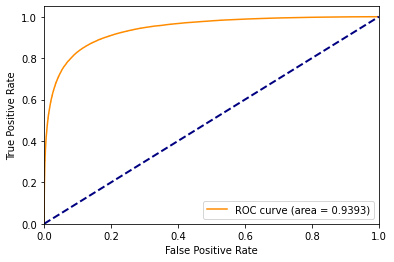

In [10]:
plot_roc_curve(model_even, odd, path_tosave, odd=False)
plot_roc_curve(model_odd, even, path_tosave, odd=True)

In [11]:
nn_scores_odd = model_even.predict(odd)
nn_scores_even = model_odd.predict(even)

fig = plt.figure(figsize=(16,8))
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
for i in range(No_Classes):
    plt.hist(nn_scores_test[test[3]==i],label = class_names[i], **histargs)
plt.legend(loc='upper center')
    #plt.hist(nn_scores_test[test[1]==0][test[3]==i],label = "Test_Background", **histargs)
plt.savefig(path_tosave+"/NN_Output_Classes.png")

# Input Correlation

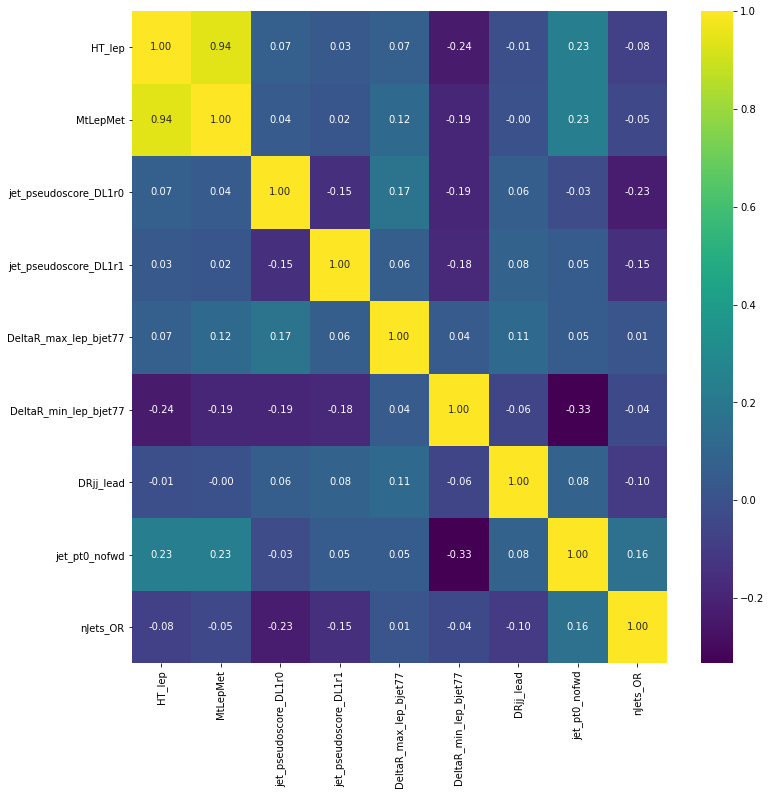

In [16]:
corr_mat = np.corrcoef(input_features, None, False)
plt.rcParams["figure.figsize"] = (12,12)
sns.heatmap(corr_mat, annot=True, cmap="viridis", xticklabels=feature_names, yticklabels=feature_names, fmt=".2f")
plt.savefig(path_tosave+"/Corr_Mat.png")

# Calc Signal cut for desired Singal Efficiency

In [17]:
Sig = nn_scores_odd[odd[1]==1]
Bkg = nn_scores_odd[odd[1]==0]
Sig_Eff, Bkg_Eff, Signal_Cut = Find_Eff_Cut(Sig=Sig, Bkg=Bkg, Signal_Eff=0.8)

Cut_Value: 0.483
Sig_Eff: 0.800
Bkg_Eff: 0.098
Bkg Rejection: 10.239


# Feature Importance

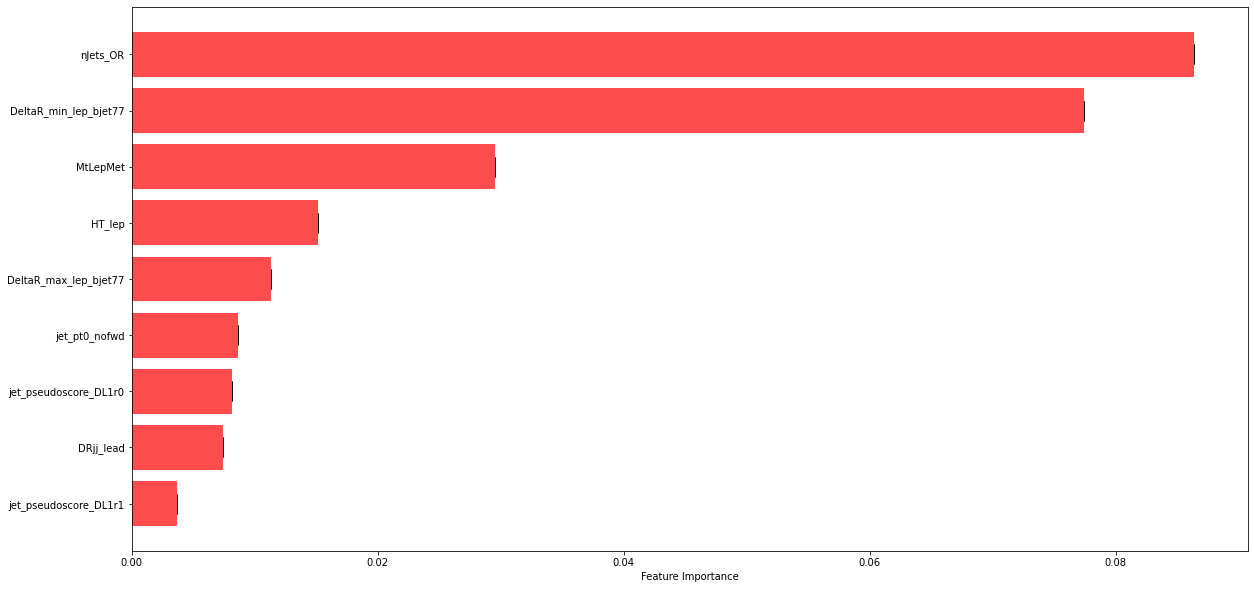

In [18]:
f, g = get_feature_importance(even, model_odd, Signal_Cut, 1)
idx = np.argsort(f)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(range(even[0].shape[1]), np.sort(f), xerr=np.array(g)[idx], color="r", alpha=0.7, ecolor='black', capsize=10)
ax.set_yticks(range(even[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')
plt.savefig(path_tosave + "/Feature_Importance_even.png")

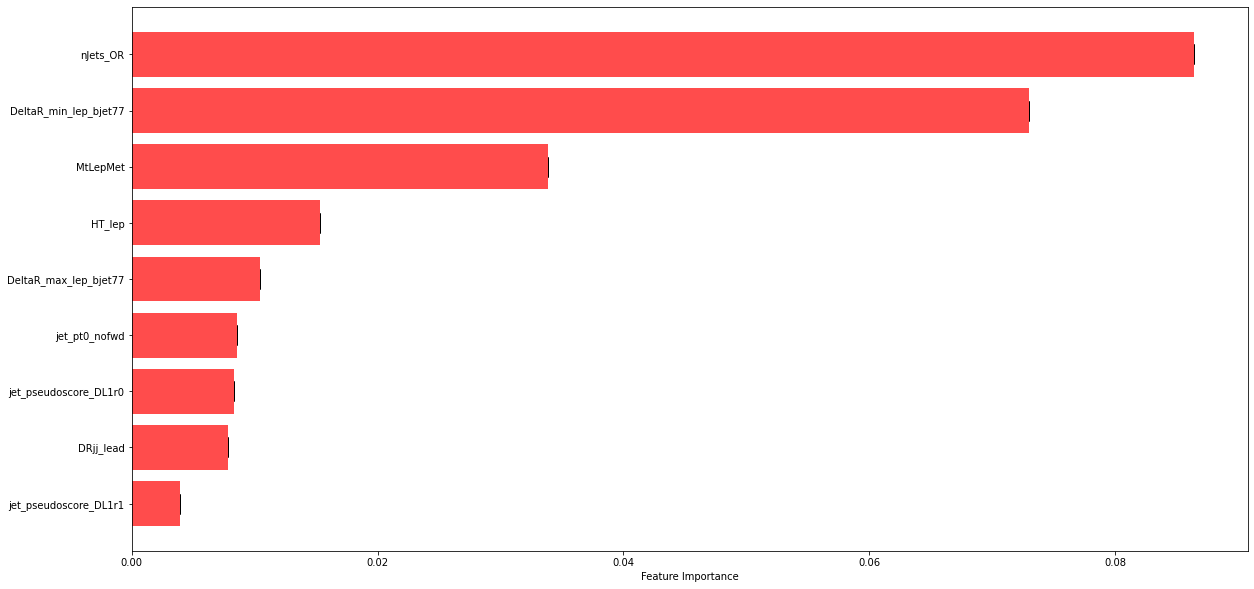

In [19]:
f, g = get_feature_importance(odd, model_even, Signal_Cut, 1)
idx = np.argsort(f)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(range(even[0].shape[1]), np.sort(f), xerr=np.array(g)[idx], color="r", alpha=0.7, ecolor='black', capsize=10)
ax.set_yticks(range(even[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')
plt.savefig(path_tosave + "/Feature_Importance_odd.png")

# Confusion Matrix

In [20]:
Sig = nn_scores_even[even[1]==1]
Bkg = nn_scores_even[even[1]==0]
Sig_Eff, Bkg_Eff, Signal_Cut_even = Find_Eff_Cut(Sig=Sig, Bkg=Bkg, Signal_Eff=0.8)

Cut_Value: 0.454
Sig_Eff: 0.800
Bkg_Eff: 0.096
Bkg Rejection: 10.372


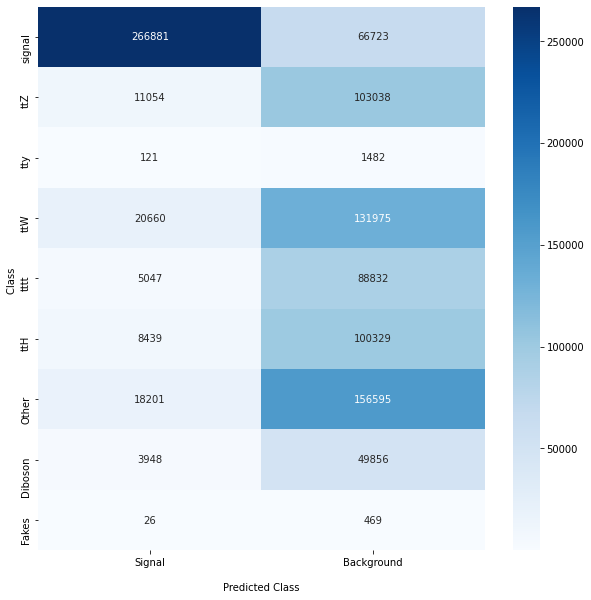

In [21]:
Make_Confusion_Matrix(even, nn_scores_even, Signal_Cut_even, class_names, path_tosave, False)

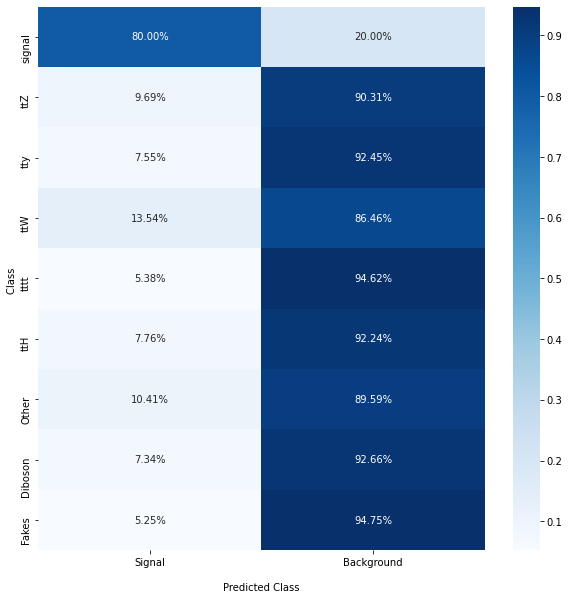

In [22]:
Make_Confusion_Matrix(even, nn_scores_even, Signal_Cut_even, class_names, path_tosave, True)

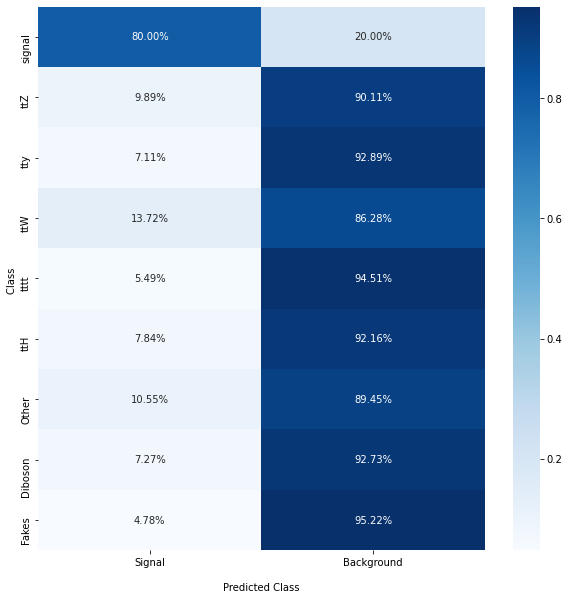

In [23]:
Make_Confusion_Matrix(odd, nn_scores_odd, Signal_Cut, class_names, path_tosave, True)

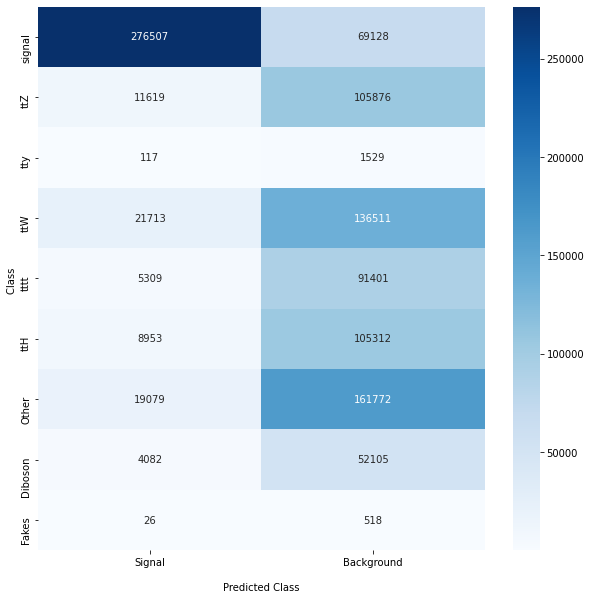

In [24]:
Make_Confusion_Matrix(odd, nn_scores_odd, Signal_Cut, class_names, path_tosave, False)

## Do Background Shape Plots

In [12]:
def Fold_Odd_Even(input, targets, weights, class_labels, Number, Dphi):
    input_odd = input[Number % 2 == 1]
    targets_odd = targets[Number % 2 == 1]
    weights_odd = weights[Number % 2 == 1]
    class_labels_odd = class_labels[Number % 2 == 1]
    input_even = input[Number % 2 == 0]
    targets_even = targets[Number % 2 == 0]
    weights_even = weights[Number % 2 == 0]
    class_labels_even = class_labels[Number % 2 == 0]
    Dphi_even = Dphi[Number % 2 == 0]
    Dphi_odd = Dphi[Number % 2 == 1]
    return (input_odd, targets_odd, weights_odd, class_labels_odd, Dphi_odd), (input_even, targets_even, weights_even, class_labels_even, Dphi_even)

In [13]:
odd, even = Fold_Odd_Even(input_scaled, targets, weights, class_labels, Number, Phi)

In [14]:
Background_Odd = odd[0][odd[1]==0]
Background_Even = even[0][even[1]==0]
Background_Odd_Dphi = odd[4][odd[1]==0]
Background_Even_Dphi = even[4][even[1]==0]
Signal_Odd = odd[0][odd[1]==1]
Signal_Even = even[0][even[1]==1]
Signal_Odd_Dphi = odd[4][odd[1]==1]
Signal_Even_Dphi = even[4][even[1]==1]

In [15]:
Signal_NN_out_odd = model_even.predict([Signal_Odd, Signal_Odd_Dphi])
Signal_NN_out_even = model_odd.predict([Signal_Even, Signal_Even_Dphi])
NN_out_Signal = np.squeeze(np.vstack([Signal_NN_out_odd, Signal_NN_out_even]))
DPhi_Signal = np.concatenate([Signal_Odd_Dphi, Signal_Even_Dphi])
NN_out_odd = model_even.predict([Background_Odd, Background_Odd_Dphi])
NN_out_even = model_odd.predict([Background_Even, Background_Even_Dphi])
NN_out_bck = np.squeeze(np.vstack([NN_out_odd, NN_out_even]))
DPhi_bck = np.concatenate([Background_Odd_Dphi, Background_Even_Dphi])

In [16]:
def Calc_Bin_Center(bins):
    bin_centers = np.zeros([bins.size-1])
    for i in range(bins.size-1):
        bin_centers[i] = (bins[i] + bins[i+1])/2
    return bin_centers

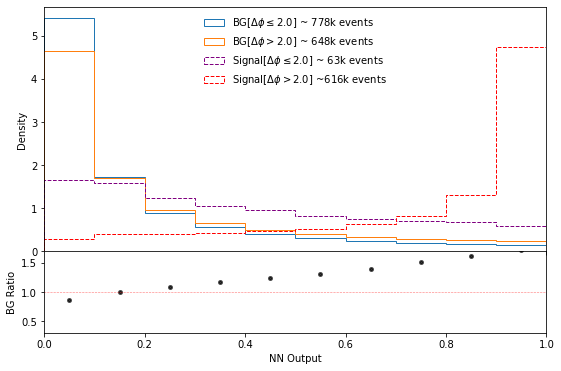

In [17]:
Dphi_Cut = 2.0

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(9,6), gridspec_kw={'height_ratios': [3, 1]})
histargs = {"bins":10, "range":(0,1.), "density":True, "histtype":'step'}
list0 = axs[0].hist(NN_out_bck[DPhi_bck <= Dphi_Cut], label=r"BG$[\Delta \phi \leq 2.0]$ ~ "+str(int(np.round(NN_out_bck[DPhi_bck <= Dphi_Cut].size/1000))) + "k events", **histargs)
list1 = axs[0].hist(NN_out_bck[DPhi_bck > Dphi_Cut], label=r"BG$[\Delta \phi > 2.0]$ ~ "+str(int(np.round(NN_out_bck[DPhi_bck > Dphi_Cut].size/1000))) + "k events", **histargs)
#axs[0].hist(NN_out_bck, label=r"Full Background", **histargs, linestyle="--")
list2 = axs[0].hist(NN_out_Signal[DPhi_Signal <= Dphi_Cut], label=r"Signal$[\Delta \phi \leq 2.0]$ ~ "+str(int(np.round(NN_out_Signal[DPhi_Signal <= Dphi_Cut].size/1000))) + "k events", **histargs, color='purple', linestyle="--")
list3 = axs[0].hist(NN_out_Signal[DPhi_Signal > Dphi_Cut], label=r"Signal$[\Delta \phi > 2.0]$ ~" +str(int(np.round(NN_out_Signal[DPhi_Signal > Dphi_Cut].size/1000))) + "k events", **histargs, color='red', linestyle="--")
bin_centers = Calc_Bin_Center(list0[1])
#xs[0].set_yscale('log')
axs[0].set_ylabel("Density")
#axs[0].set_xlabel(r"NN Output")
axs[0].legend(frameon=False, loc='upper center')
Frac = list1[0]/list0[0]
axs[1].scatter(bin_centers, Frac, marker='.', linewidth=2, color='black', alpha=0.7)
axs[1].set_ylabel(r"BG Ratio")
axs[1].set_ylim(0.3,1.7)
axs[1].hlines(1, -0.1, 1.1, alpha=0.5, linestyle='--', color='red', linewidth=0.6)
#axs[1].grid()
plt.subplots_adjust(hspace=0)
plt.xlim(0,1)
plt.xlabel(r"NN Output")
plt.savefig(path_tosave + '/Background_compare.png')

In [18]:
predict_odd = np.squeeze(model_even.predict(odd[0]))

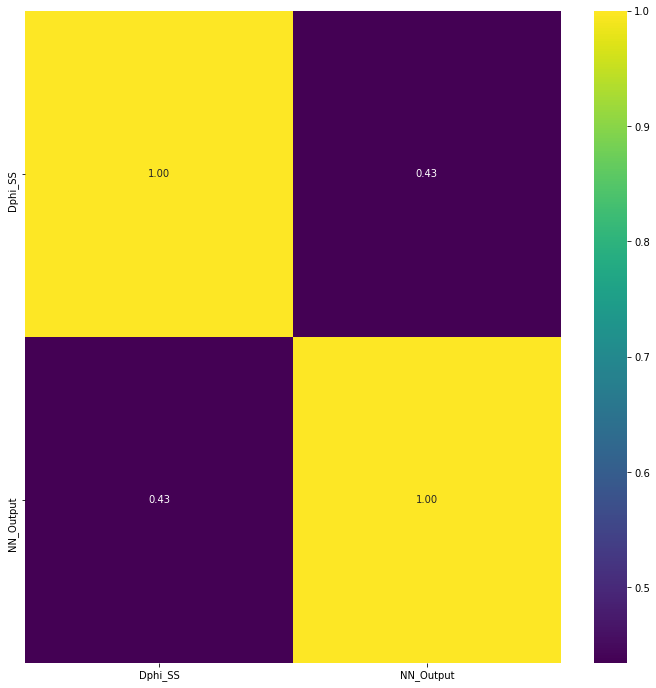

In [19]:
corr_mat = np.corrcoef(np.vstack([odd[4], predict_odd]).T, None, False)
plt.rcParams["figure.figsize"] = (12,12)
sns.heatmap(corr_mat, annot=True, cmap="viridis", xticklabels=["Dphi_SS", "NN_Output"], yticklabels=["Dphi_SS", "NN_Output"], fmt=".2f")

plt.savefig(path_tosave+"/Corr_Dphi_NNout.png")